<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/01-Pandas/A3-Advanced_Data_Manipulation_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pandas beyond SQL: Advanced Data Manipulation Techniques

Install the necessary libraries to connect to MySQL and to read Excel files

In [26]:
# @title Setup and preliminaries

!pip3 install -U -q PyMySQL sqlalchemy

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Render our plots with high resolution
%config InlineBackend.figure_format = 'retina'

# Make the graphs a bit bigger
matplotlib.style.use(["seaborn-v0_8-talk", "seaborn-v0_8-ticks", "seaborn-v0_8-whitegrid"])

# Setting the default figure size for Pandas plots
pd.options.plotting.backend = 'matplotlib'
plt.rcParams['figure.figsize'] = [10, 3]

In [27]:
# @title MySQL Setup

import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2015',
    db = 'doh_restaurants',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

# This query returns back the restaurants in the DOH database
sql = '''
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO,
          R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, R.NTA
		FROM doh_restaurants.restaurants R
'''

with engine.connect() as connection:
	restaurants = pd.read_sql(text(sql), con=connection)

# This query returns back the results of the inspections of each restaurant
sql = '''
	SELECT R.CAMIS, R.DBA, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.NTA,
				 I.INSPECTION_DATE, I.INSPECTION_ID,
				 I.INSPECTION_TYPE, I.SCORE, I.GRADE
	FROM restaurants R
		JOIN inspections I ON I.CAMIS = R.CAMIS
'''

with engine.connect() as connection:
	inspections = pd.read_sql(text(sql), con=connection)

# Pivot Tables



## Simple pivot tables

[Pivot tables](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) is one of the most commonly used exploratory tools, and in Pandas they are extremely flexible.

In their simplest form, they can generate the same results as aggregate queries.

In [28]:
rest_per_boro = pd.pivot_table(
    data=restaurants,
    aggfunc="count",  # we count... (the aggregation function)
    values="CAMIS",  # ...the different CAMIS numbers (what we aggregate)
    index="BORO",  # ..per BORO (and how we specify the groups, ie the variable that we use for dividing the data)
)


In [29]:
# The full pivot table
rest_per_boro

,CAMIS
BORO,
Bronx,1818
Brooklyn,5156
Manhattan,7579
Queens,4438
Staten Island,751


Or, let's try to examine the average inspection score, broken down by cuisine.

In [30]:
score_per_cuisine = pd.pivot_table(
    data=inspections,
    index="CUISINE_DESCRIPTION",  # specifies the rows
    values="SCORE",  # specifies the content of the cells
    aggfunc="mean",  # we calculate the average/mean score
)

In [31]:
# The full pivot table
score_per_cuisine

,SCORE
CUISINE_DESCRIPTION,
Afghan,14.440000
African,26.276119
American,14.864405
Asian/Asian Fusion,19.804598
Australian,15.927273
...,...
Tex-Mex,13.247268
Thai,19.934236
Turkish,19.000000


<Axes: ylabel='CUISINE_DESCRIPTION'>

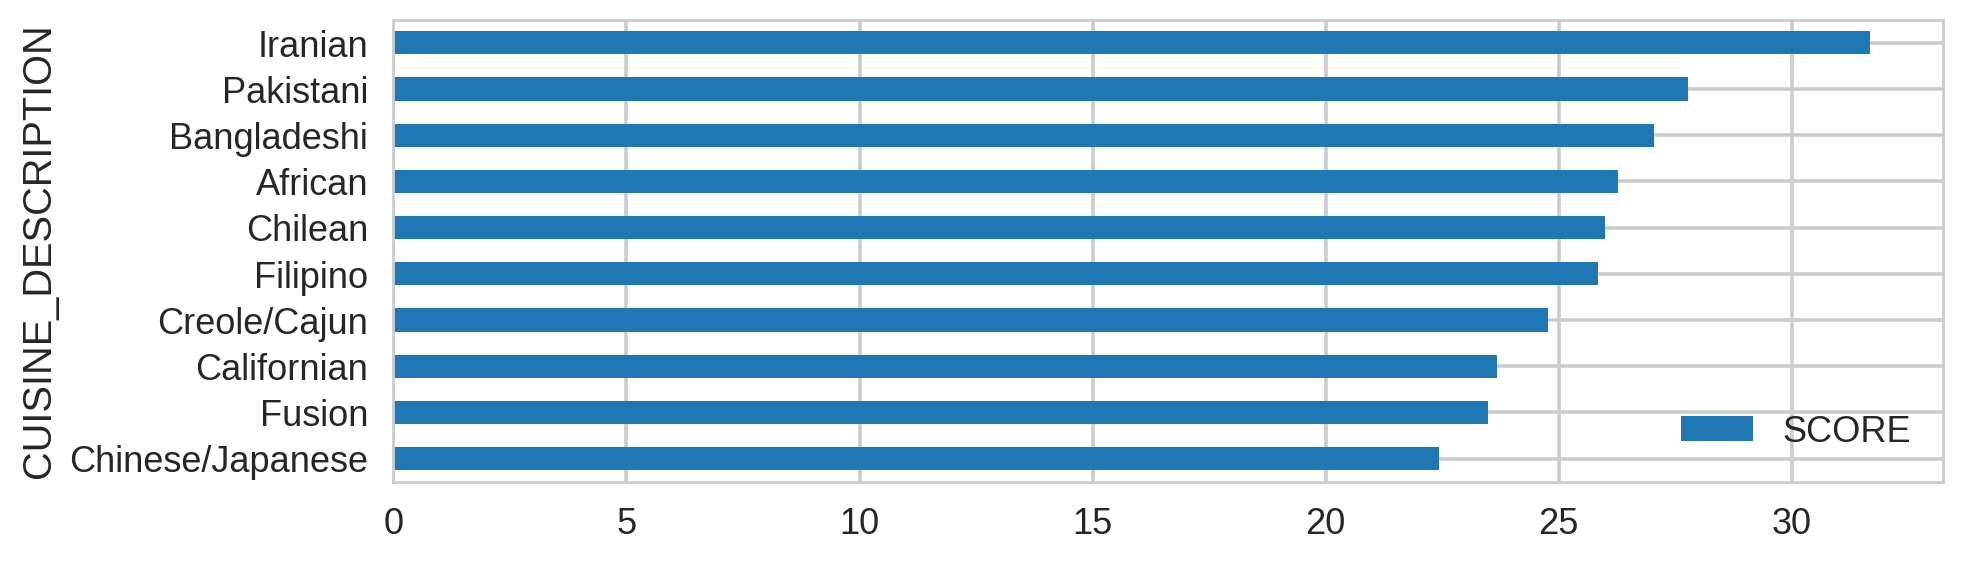

In [32]:
# Plotting the scores of the 10 highest scoring cuisines
(
    score_per_cuisine
    .sort_values('SCORE') # sort in asceding order of score
    .tail(10) # take the 10 entries in the largest values (at the botoom)
    .plot(kind='barh') # create a bar plot
)

### Exercise

Show the average inspection score broken down by neighborhood code (the `NTA` variable).

### Pivot Tables and Dates

In [33]:
# Count the number of CAMIS values that appear on each date
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="CAMIS",  # specifies the content of the cells
    aggfunc="count",  # we ask to count how many different CAMIS values we see
)

In [34]:
pivot

,CAMIS
INSPECTION_DATE,
2015-10-14,1
2015-11-19,1
2015-11-20,1
2015-12-01,1
2015-12-12,1
...,...
2024-05-20,107
2024-05-21,86
2024-05-22,99


Now, let's plot this. By default, Pandas considers the "index" column to be the x-axis, and plots the rest.

<Axes: xlabel='INSPECTION_DATE'>

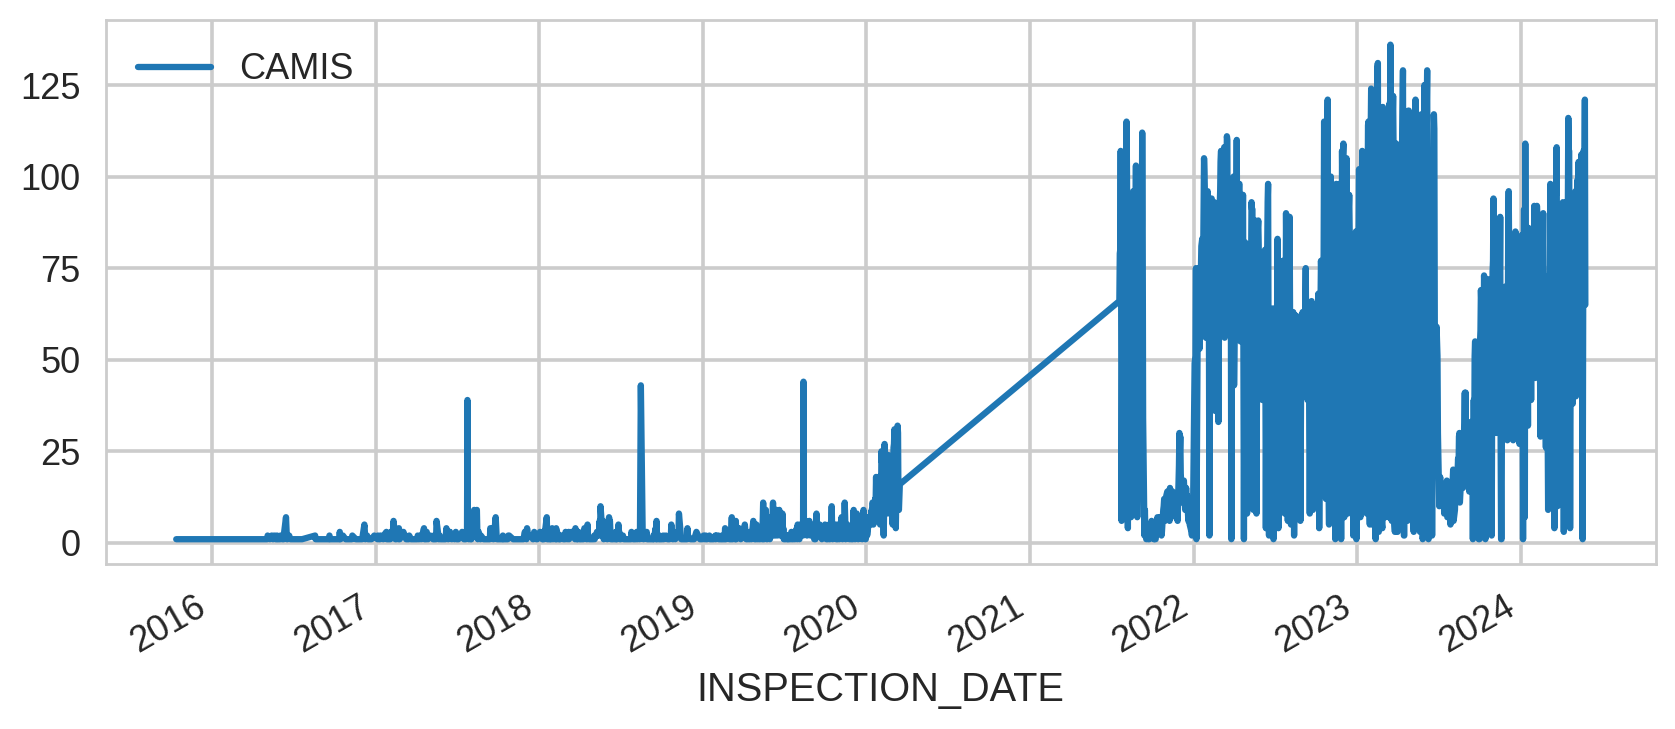

In [35]:
pivot.plot(kind = 'line', y = 'CAMIS', figsize=(10, 4))

<Axes: xlabel='INSPECTION_DATE'>

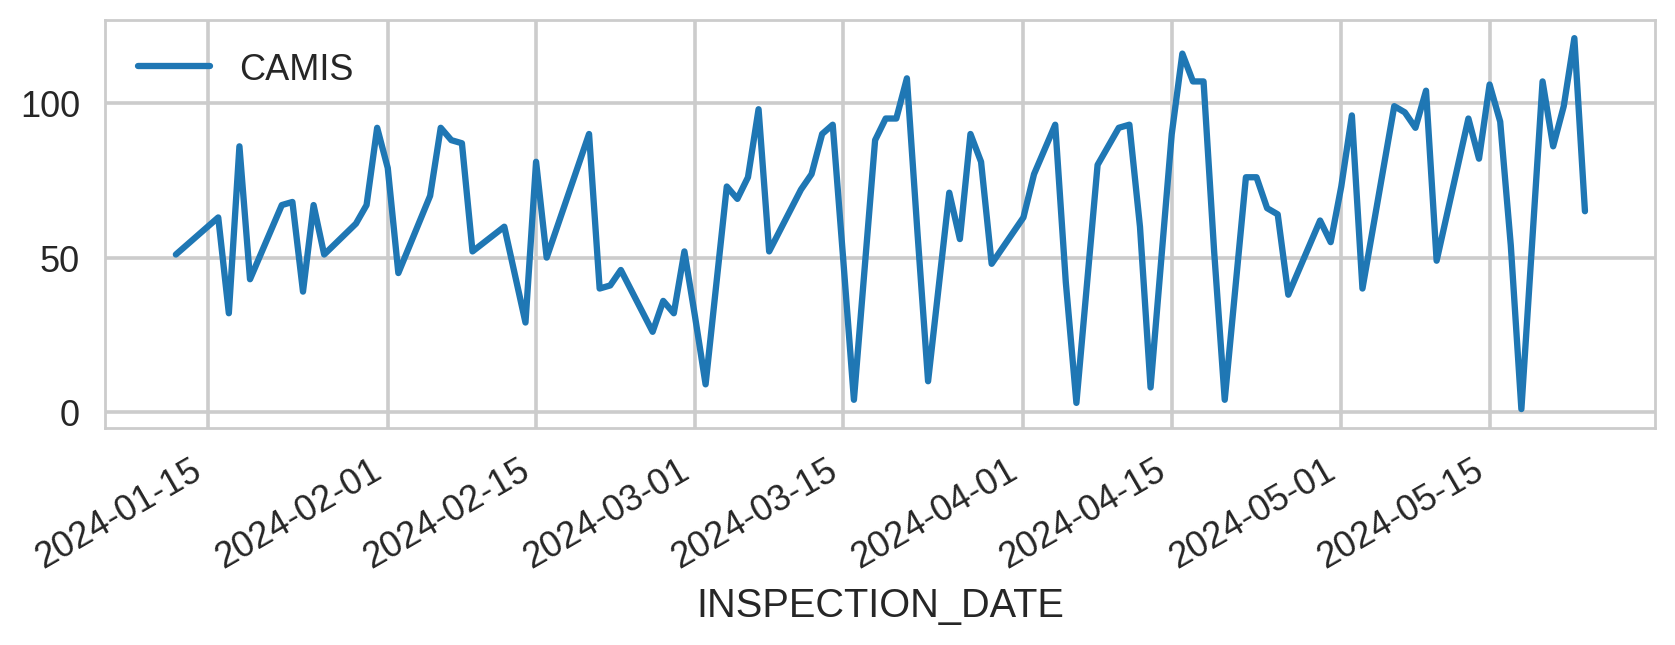

In [36]:
# We keep the last 100 entries and plot
pivot.tail(100).plot()

### Exercise

Now let's do an exercise,  instead of counting the number of inspections, we want to compute the average score assigned by the inspectors. Hint: We will need to change the `values` and the `aggfunc` parameters in the `pivot_table` function above.

In [37]:
# your code here

#### Solution

In [38]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="SCORE",  # specifies the content of the cells
    aggfunc="mean",  # compute the average SCORE
)

<Axes: xlabel='INSPECTION_DATE'>

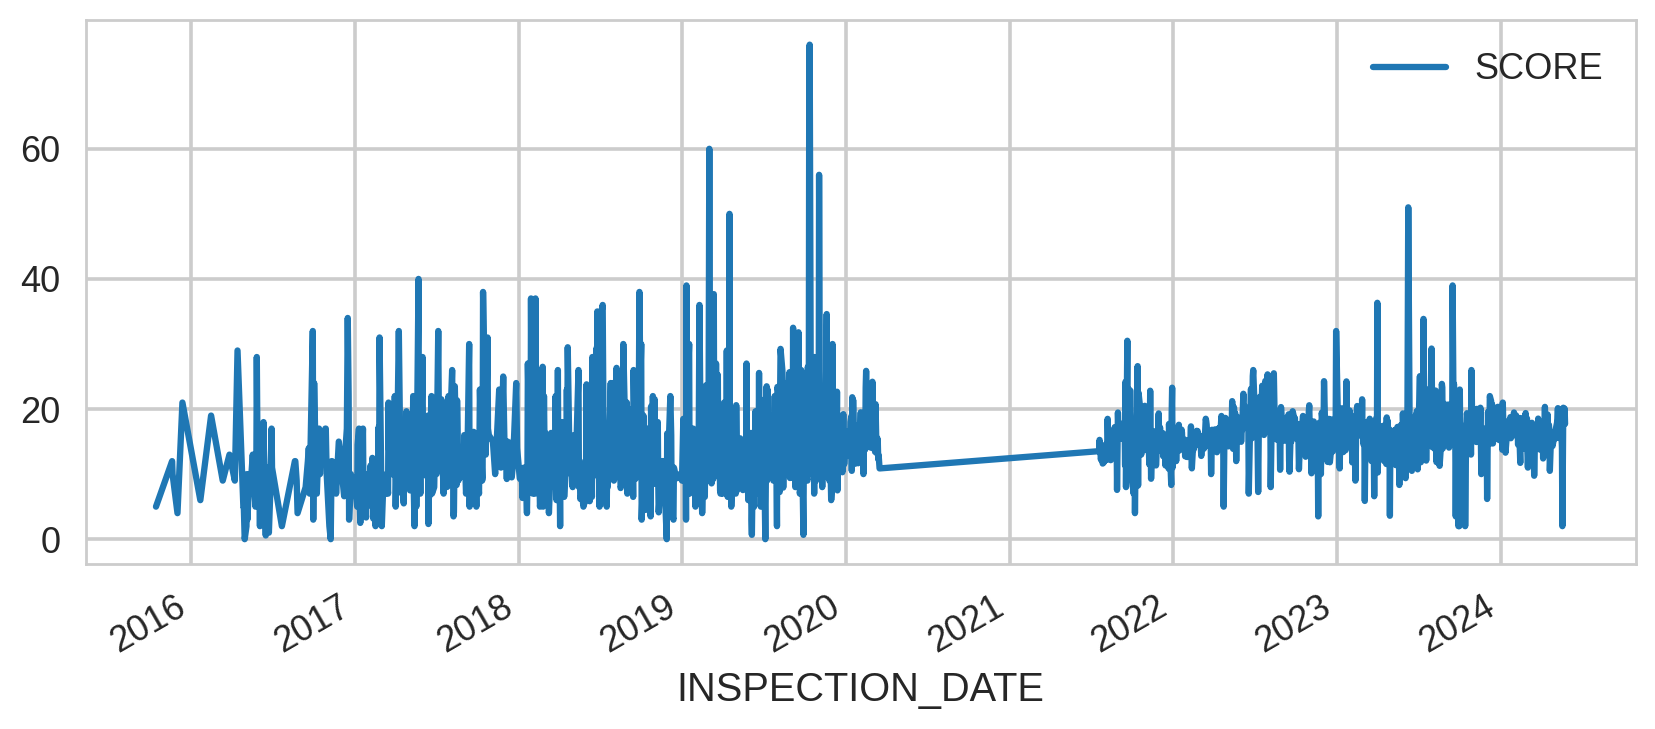

In [39]:
pivot.plot(figsize=(10, 4))

### Changing date granularity

We can also use the [resample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) command to change the frequency from one day, to, say, 7 days. Then we can compute, say, the average (`mean()`) for these days, or the total number (`sum()`) of inspections.

In [40]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="CAMIS",  # specifies the content of the cells
    aggfunc="count",  # we ask to count how many different CAMIS values we see
)

pivot.resample("1W").sum()

,CAMIS
INSPECTION_DATE,
2015-10-18,1
2015-10-25,0
2015-11-01,0
2015-11-08,0
2015-11-15,0
...,...
2024-04-28,320
2024-05-05,326
2024-05-12,441


Now, let's plot this. By default, Pandas considers the "index" column to be the x-axis, and plots the rest.

<Axes: xlabel='INSPECTION_DATE'>

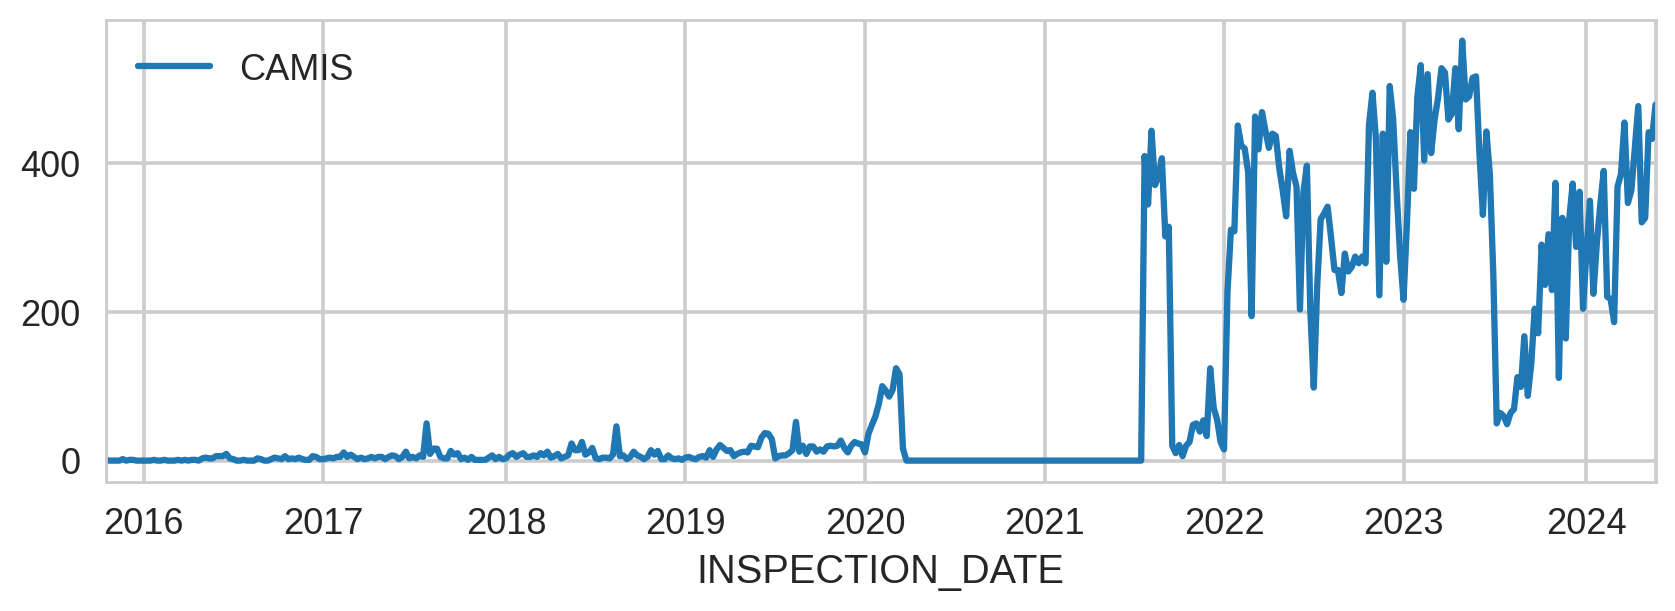

In [41]:
# Plot the average number of inspections, over 7-day periods
pivot.resample("1W").sum().plot()

<Axes: xlabel='INSPECTION_DATE'>

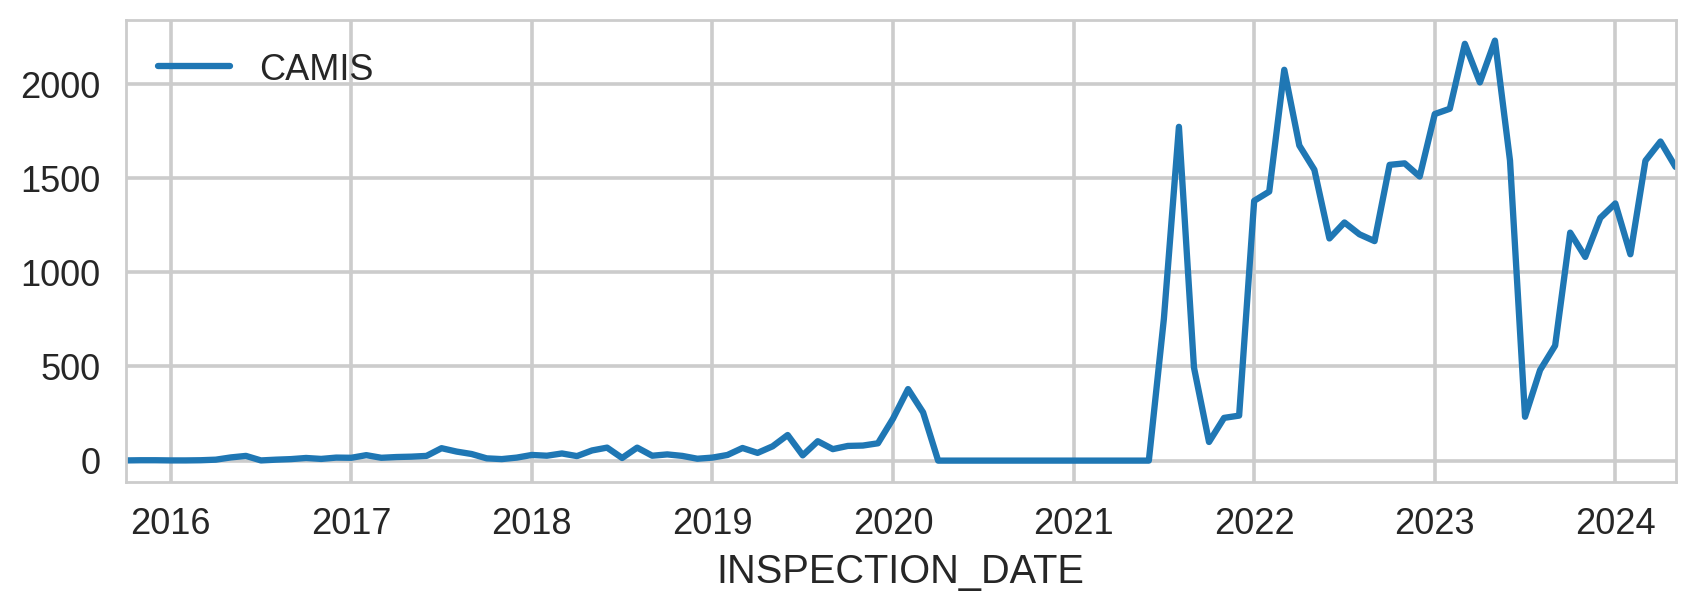

In [42]:
# Plot the total number of inspections, over 1-month periods
pivot.resample("1M").sum().plot()

Text(0.5, 1.0, 'Analysis of Number of Inspections over Time')

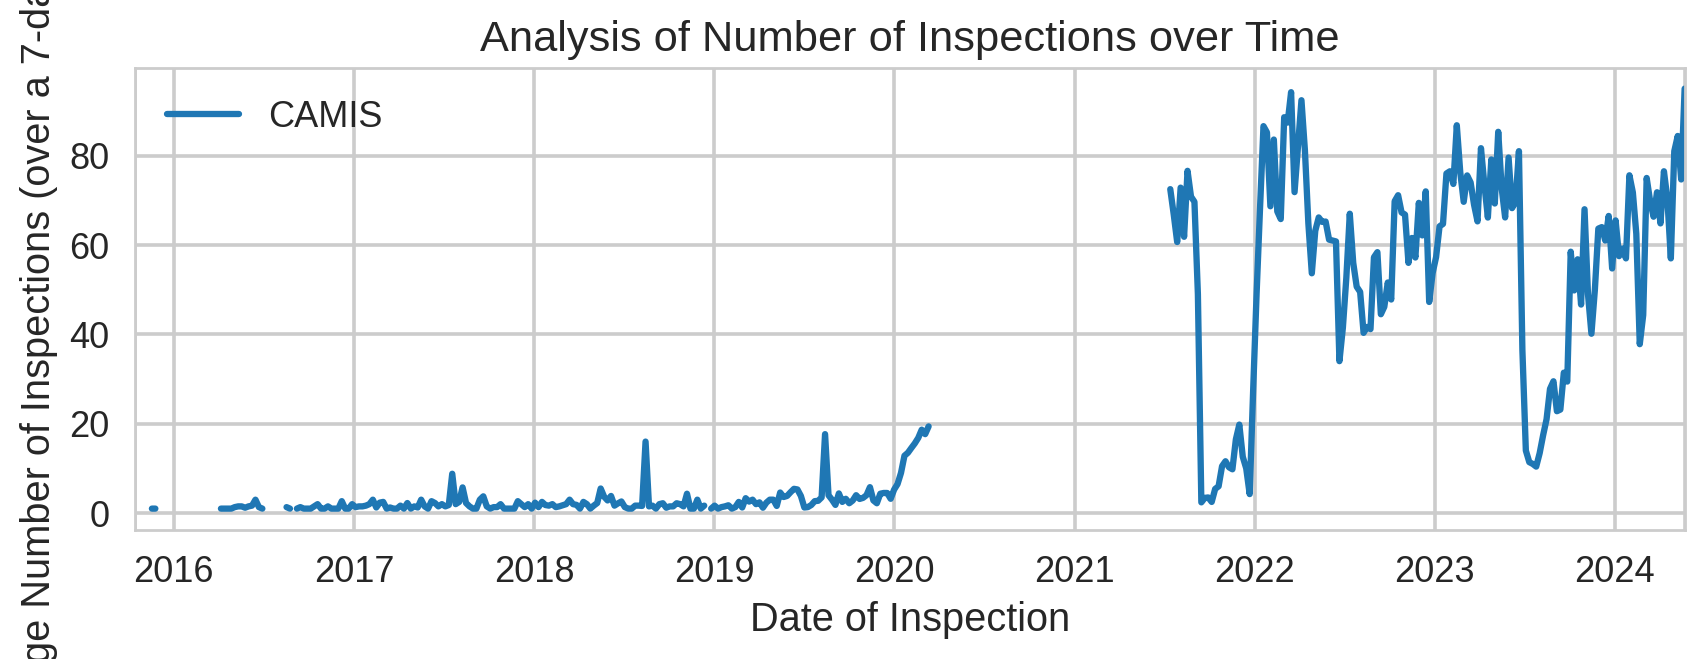

In [43]:
plot = pivot.resample("7D").mean().plot()
plot.set_xlabel("Date of Inspection")
plot.set_ylabel("Average Number of Inspections (over a 7-day period)")
plot.set_title("Analysis of Number of Inspections over Time")

## Pivot Table with two (or more) variables

We would like to break down the results by borough, so we add the `column` parameter.

In [44]:
# Show grades broken down by borough
pivot2 = pd.pivot_table(
    data=inspections,  #
    index="GRADE",
    columns="BORO",
    values="CAMIS",
    aggfunc="count"
)
pivot2

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
GRADE,,,,,
A,2437,7781,11029,6408,1211
B,286,677,844,584,110
C,78,271,319,226,21


<Axes: xlabel='GRADE'>

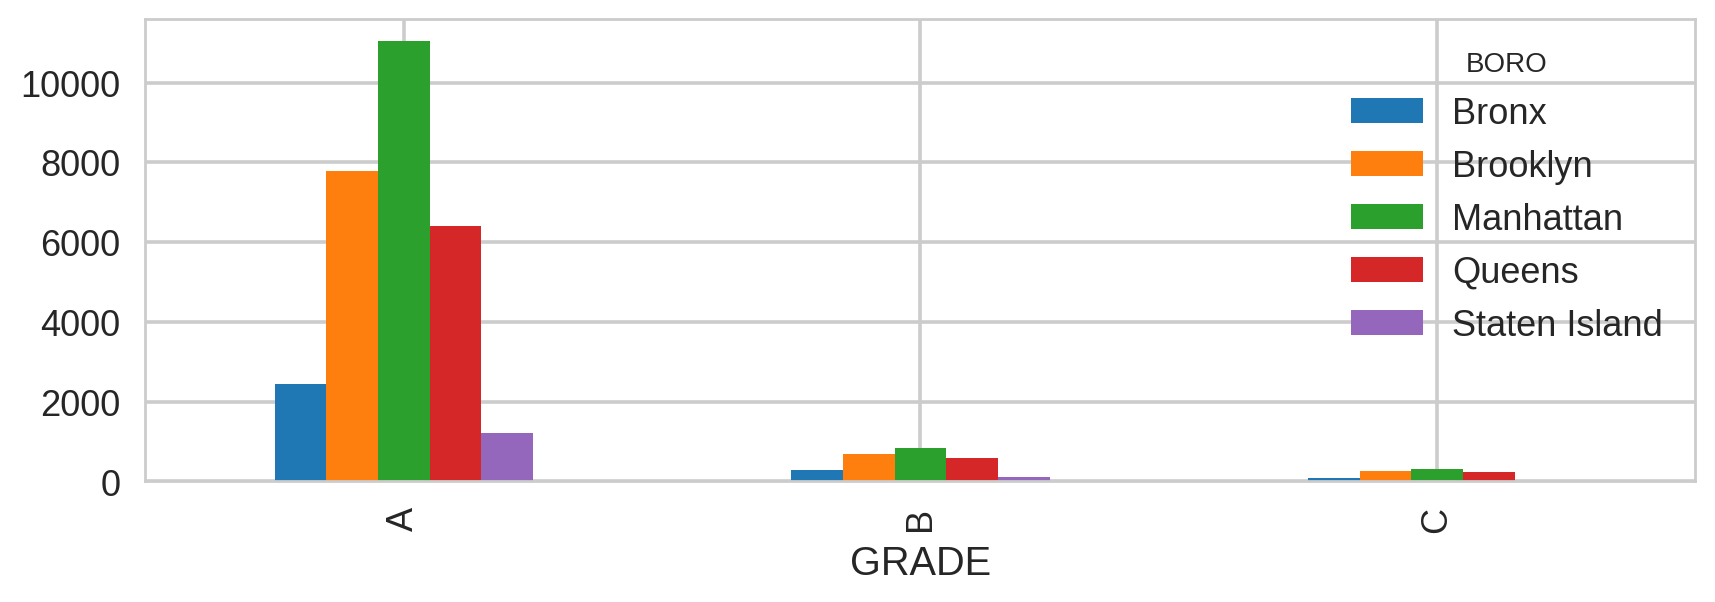

In [45]:
# By default, the "index" becomes the x-axis and we plot all numeric columns
pivot2.plot(kind='bar')

## Advanced Pivot Tables

We can also add multiple attributes in the index and columns. It is also possible to have multiple aggregation functions, and we can even define our own aggregation functions.

In [54]:
# We break down by BORO and GRADE, and also calculate
# inspections scores
pivot_advanced = pd.pivot_table(
    data=inspections,  #
    index="INSPECTION_DATE",
    columns=["BORO", "GRADE"],
    values="SCORE",
    aggfunc=["mean", "std"],
)

# Take the total number of inspections (unique and non-unique)
agg = pivot_advanced.resample("1M").mean()

# Show the last 5 entries and show the transpose (.T)
agg.tail().T

INSPECTION_DATE           2024-01-31  2024-02-29  2024-03-31  2024-04-30  \
     BORO          GRADE                                                   
mean Bronx         A        9.731944    9.618519    9.960873    9.939773   
                   B             NaN   22.285714   21.261905   24.500000   
                   C       29.000000   37.800000   31.000000   43.250000   
     Brooklyn      A        8.857733    8.876359    9.248848    9.283321   
                   B       22.714286   21.523333   21.975000   22.102564   
                   C       42.666667   37.222222   43.062500   31.833333   
     Manhattan     A        9.965173    9.712978    9.496997    9.400798   
                   B       22.357143   21.066667   22.474510   22.218182   
                   C       50.666667   41.527778   44.854167   33.916667   
     Queens        A        9.192981    9.749933   10.028970    9.326833   
                   B       22.142857   23.666667   21.318627   22.954545   
                   C       37.666667   39.400000   41.772727   36.916667   
     Staten Island A        9.469608    8.607143   10.280702    9.740833   
                   B             NaN   24.000000   21.928571   25.000000   
                   C             NaN   43.000000   34.000000         NaN   
std  Bronx         A        2.634934    2.420346    2.753635    2.591822   
                   B             NaN         NaN    3.203747    0.000000   
                   C             NaN         NaN         NaN         NaN   
     Brooklyn      A        3.651394    3.424812    3.342880    3.364280   
                   B        7.071068    3.594940    3.419180    2.980055   
                   C             NaN    9.899495   10.401811    2.121320   
     Manhattan     A        3.102645    2.929992    3.120410    3.157873   
                   B        4.949747    3.733154    3.387563    2.799511   
                   C       11.532563    5.155591   14.832378    0.353553   
     Queens        A        3.212035    2.949398    3.089839    3.202831   
                   B        5.656854    2.267767    3.989975    3.712311   
                   C             NaN         NaN    8.720984    0.707107   
     Staten Island A        2.714102    2.825454    2.565435    2.673698   
                   B             NaN         NaN    1.649916    0.000000   
                   C             NaN         NaN         NaN         NaN   

INSPECTION_DATE           2024-05-31  
     BORO          GRADE              
mean Bronx         A        8.284524  
                   B             NaN  
                   C             NaN  
     Brooklyn      A        8.842086  
                   B       23.333333  
                   C       31.000000  
     Manhattan     A        8.999405  
                   B             NaN  
                   C       34.000000  
     Queens        A        9.415970  
                   B       19.666667  
                   C       57.000000  
     Staten Island A        8.933333  
                   B             NaN  
                   C             NaN  
std  Bronx         A        3.430053  
                   B             NaN  
                   C             NaN  
     Brooklyn      A        3.549210  
                   B             NaN  
                   C             NaN  
     Manhattan     A        3.381886  
                   B             NaN  
                   C             NaN  
     Queens        A        3.536084  
                   B             NaN  
                   C             NaN  
     Staten Island A        3.298450  
                   B             NaN  
                   C             NaN

# Normalization, with application to Pivot Tables (and beyond)

In [46]:
# Let's say that we want to normalize the values
# to account for the different number of inspections
# in each borough
pivot2.sum()

BORO
Bronx             2801
Brooklyn          8729
Manhattan        12192
Queens            7218
Staten Island     1342
dtype: int64

In [47]:
# This command normalizes each column, by dividing with its sum:
pivot2 / pivot2.sum()

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
GRADE,,,,,
A,0.870046,0.891396,0.904610,0.887781,0.902385
B,0.102106,0.077558,0.069226,0.080909,0.081967
C,0.027847,0.031046,0.026165,0.031311,0.015648


<Axes: xlabel='GRADE'>

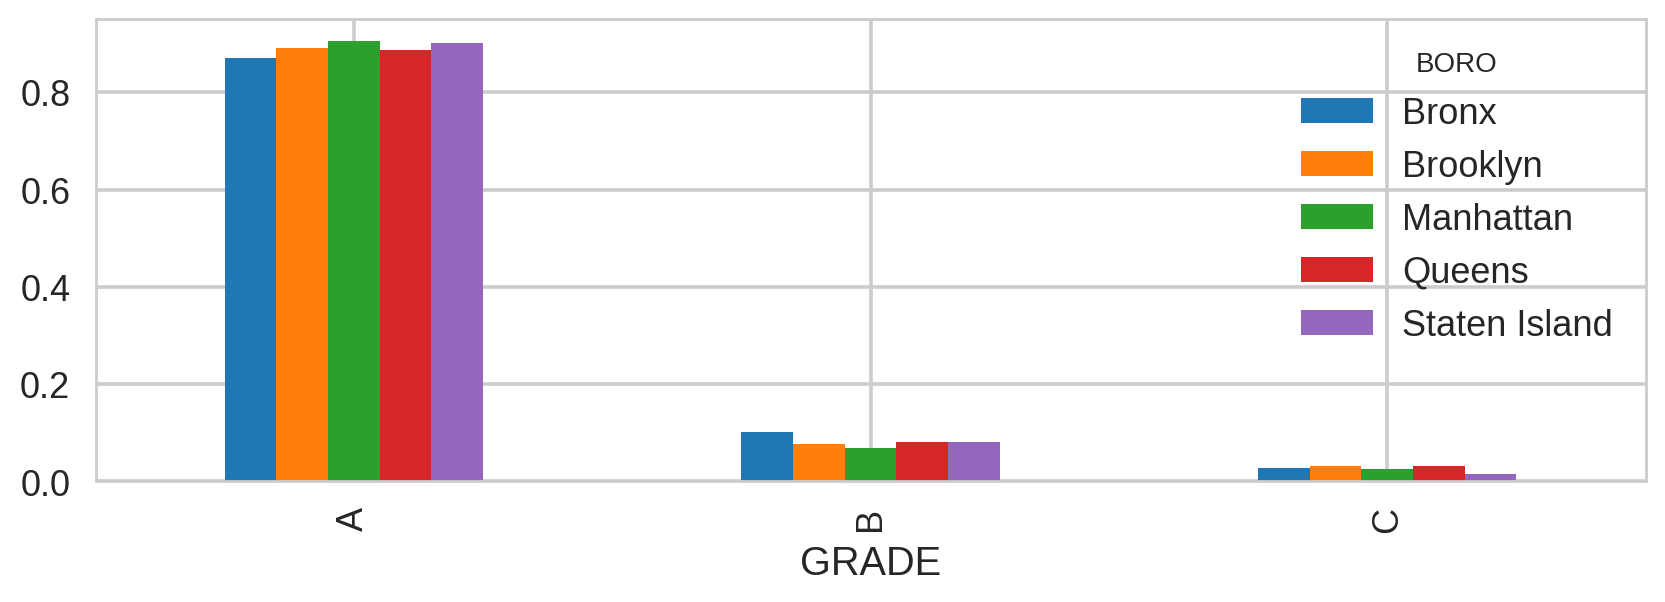

In [48]:
normalized_by_borough = pivot2 / pivot2.sum()

# Percent of inspections per borough with a given grade
normalized_by_borough.plot(kind='bar')

#### Normalization and Transpose

In [49]:
# This takes the transpose of the dataframe
pivot2.T

GRADE,A,B,C
BORO,,,
Bronx,2437,286,78
Brooklyn,7781,677,271
Manhattan,11029,844,319
Queens,6408,584,226
Staten Island,1211,110,21


<Axes: ylabel='BORO'>

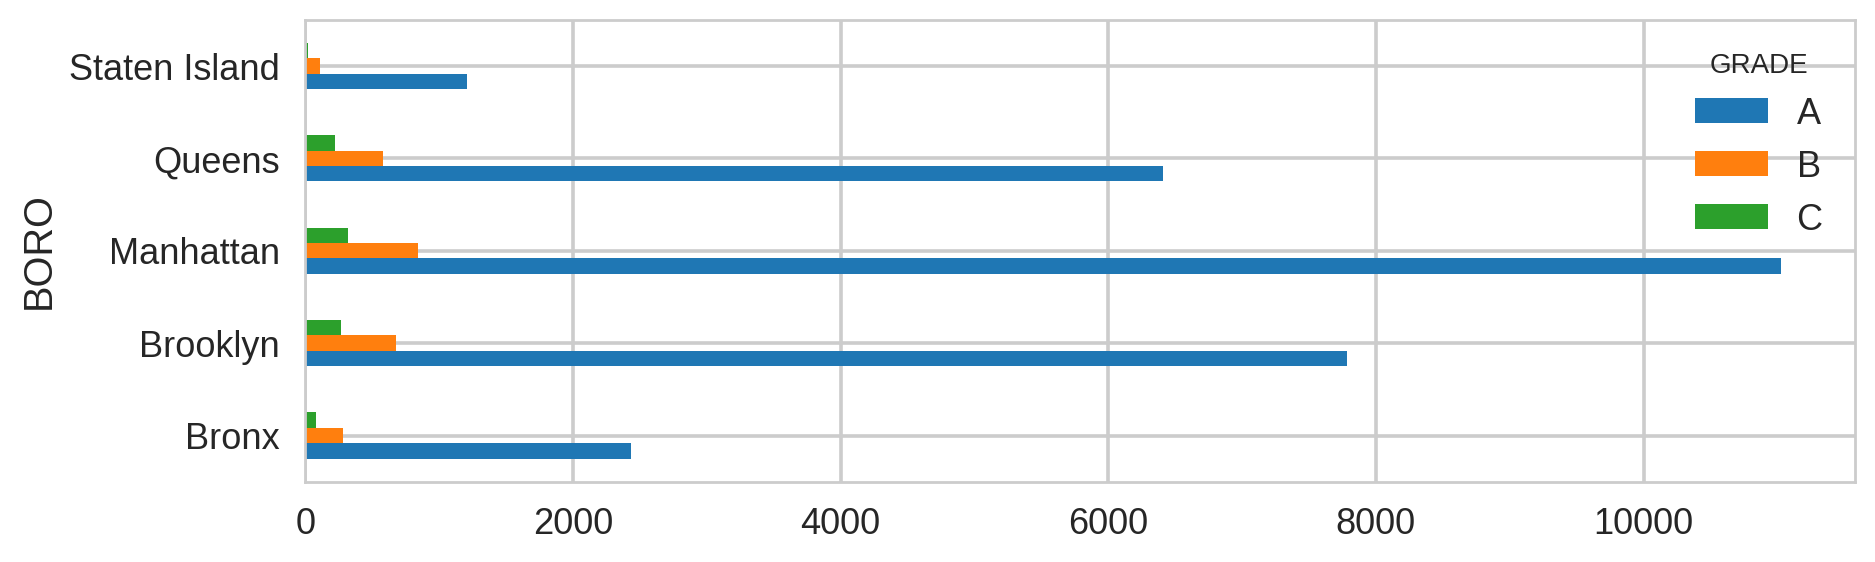

In [50]:
# Plotting the transpose now uses the boroughs as the "x" axis
pivot2.T.plot(kind='barh')

<Axes: ylabel='BORO'>

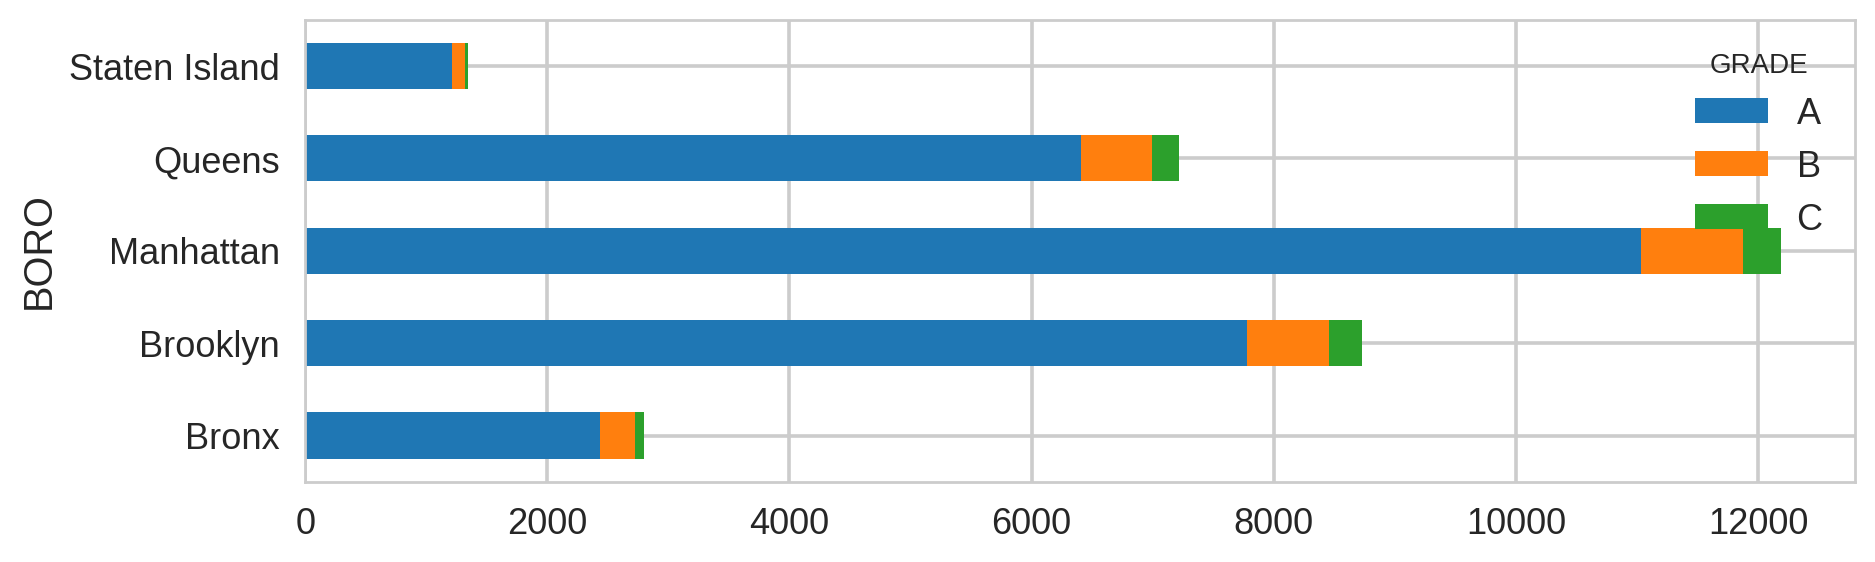

In [51]:
# Variation,
pivot2.T.plot(kind='barh', stacked=True)

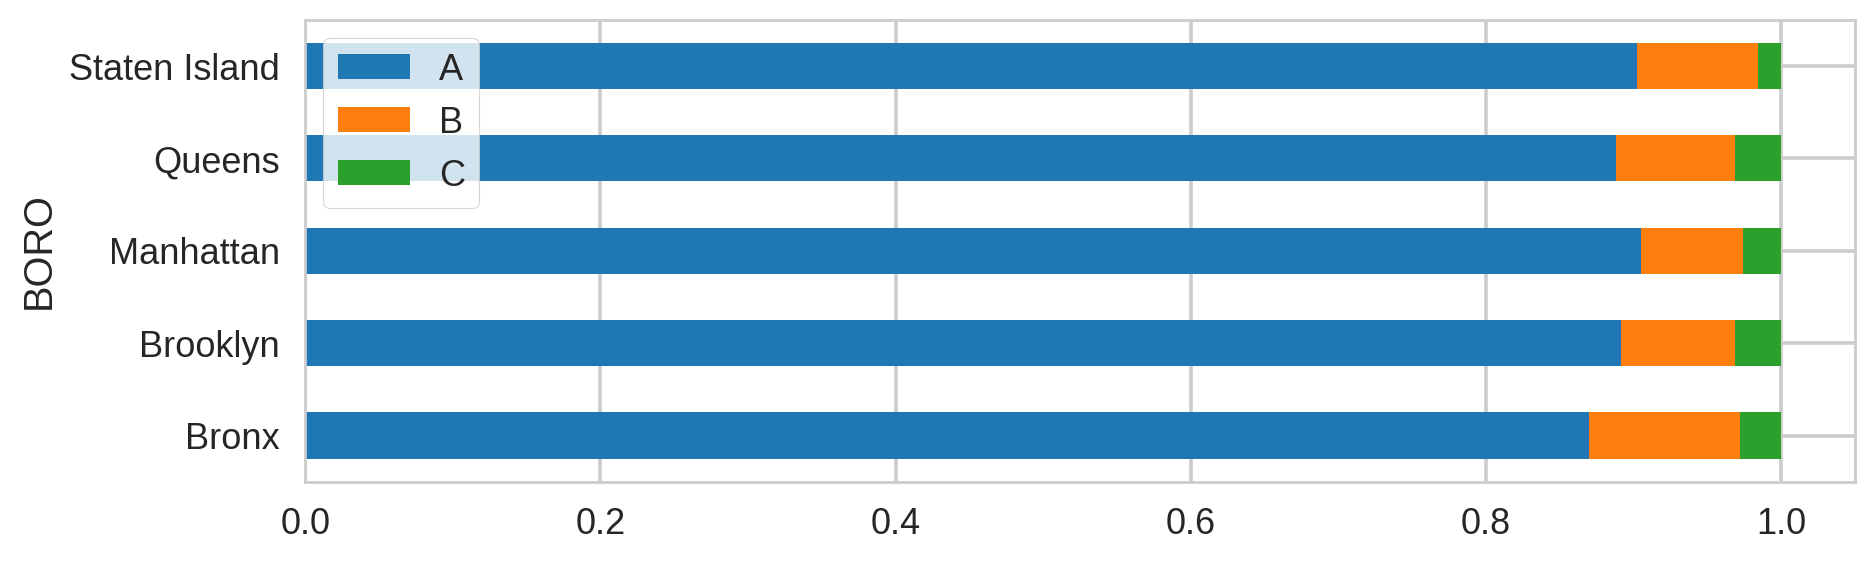

In [52]:
normalized_by_borough.T.plot(kind='barh', stacked=True).legend(frameon=True)



### Exercise

We now want to examine if different cuisines have different inspection scores. Compute the average inspection score by cuisine. Use the `sort_values()` command ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html)) to order cuisines by their inspection scores. Analyze further by breaking down the score over inspection dates, and plot.

#### Solution

In [108]:
popular = (
    pd.pivot_table(
    data=inspections,
    index="CUISINE_DESCRIPTION",  # cuisines are the rows
    values="SCORE",  # we analyze the SCORE
    aggfunc=["mean","count"]  # compute the average SCORE
    )
    .sort_values(by=('count','SCORE'), ascending=False) # sort according to the popularity (count) of each cuisine
    .head(4) # keep the top-4 most popular cuisined
    .index # keep the names of the cuisines, which appear in the index
    .values # and retrieve their values
)

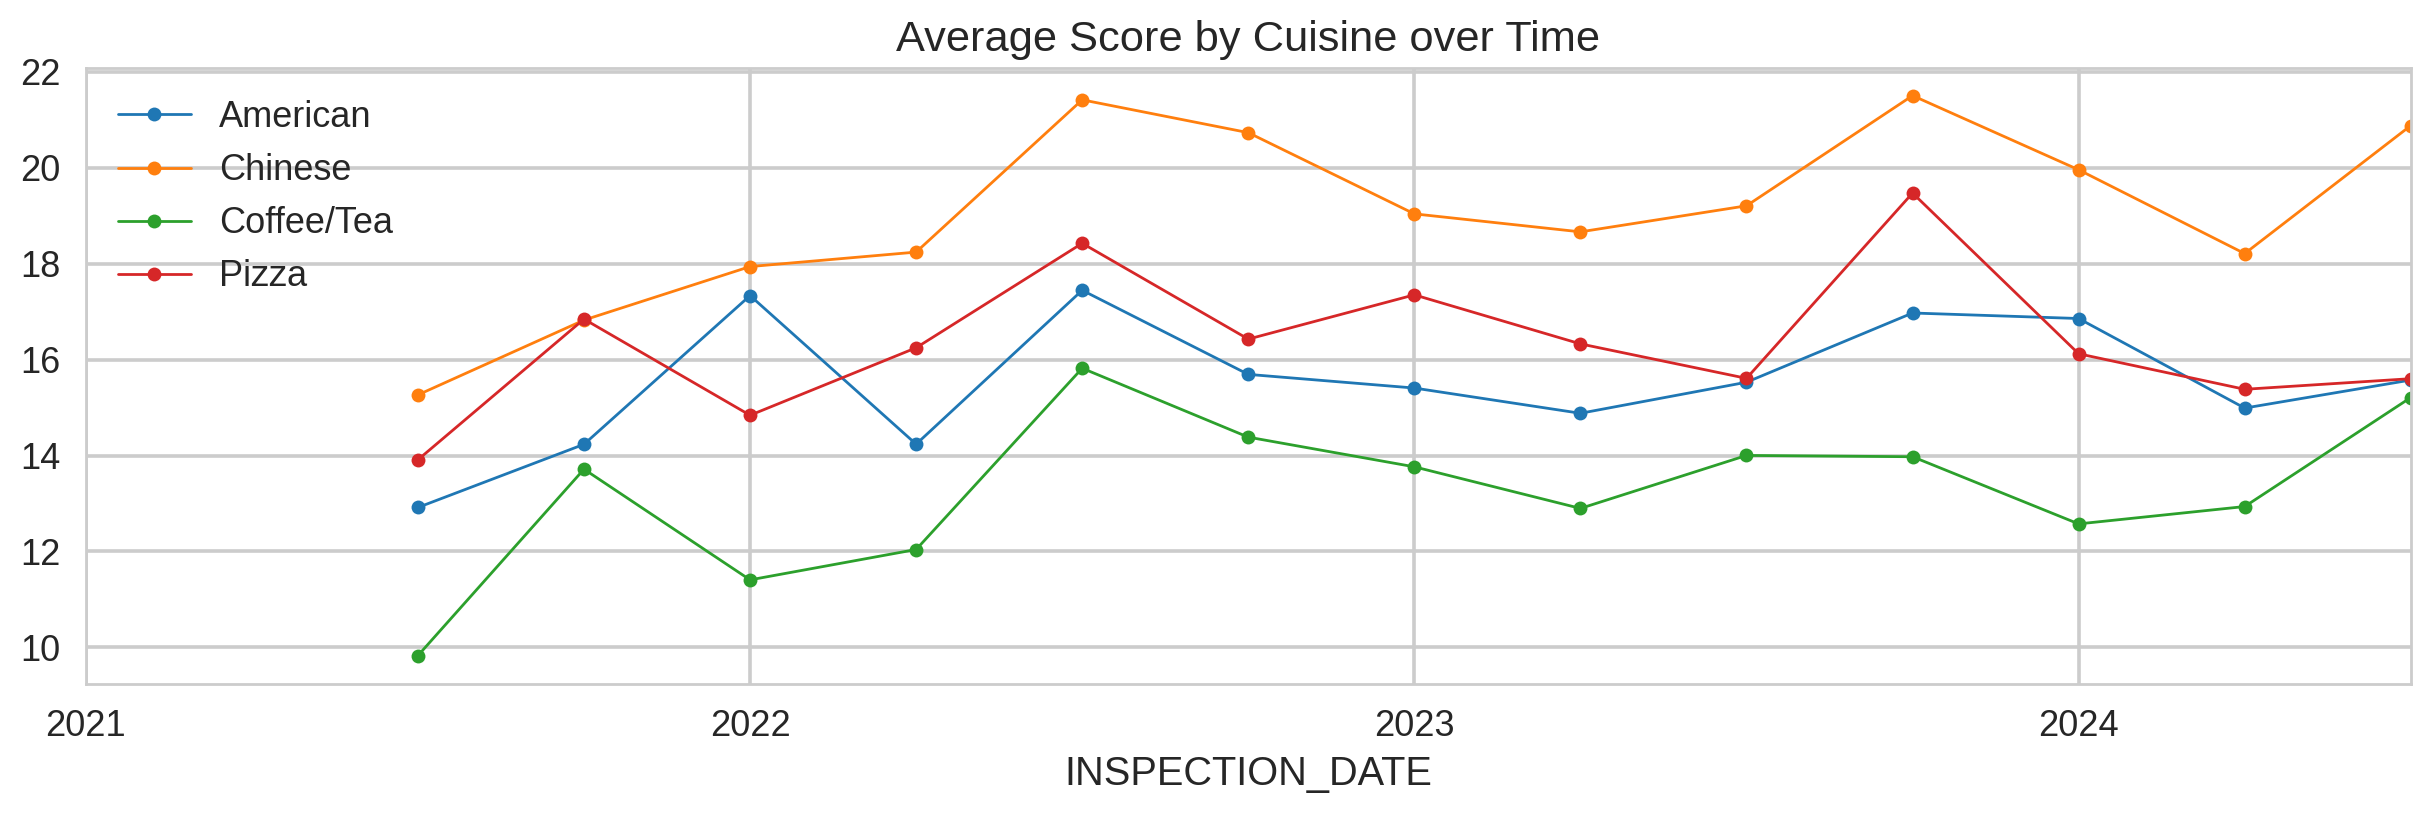

In [112]:
# Select 3 columns (american, frenchn, chinese), compute the average score for a month
# and plot the results
(
    pd.pivot_table(
        data=inspections,
        index="INSPECTION_DATE",  # dates are the rows
        columns="CUISINE_DESCRIPTION",  # cuisines are the columns
        values="SCORE",  # we analyze the SCORE
        aggfunc="mean"  # compute the average SCORE
    )
    .filter(popular) # keep only the popular cuisines
    .resample("3M").mean() # convert granularity to monthly and taking average score
    .reset_index() # we take the INSPECTION_DATE out of the index to query and limit the x-axis
    .query("INSPECTION_DATE > '2021-01-01' ") # keep only dates after 2001
    .plot(
        kind = 'line',
        marker = 'o', markersize = 5, linewidth = 1,
        x = "INSPECTION_DATE",
        y = popular,
        figsize=(15, 4),
        title = "Average Score by Cuisine over Time"
      ).legend(
          loc='upper left',
          facecolor='white', edgecolor='black'
      )
)

In [55]:
# your code here

# Defining new columns -- `assign()` and `apply()`



### Using the `assign()` approach

The `assign` command applies a function to a dataframe and returns back a new dataframe with the new column(s).

In [56]:
# We define functions that take as input a dataframe df
# and return back a new column.

# This function combines STREET/BUILDING/BORO/ZIPCODE columns into one address
#
def combine_address(df):
  return (df.BUILDING + ' ' + df.STREET + ', ' + df.BORO + ', NY ' + df.ZIPCODE).str.upper()


# This function computes the distance (in miles) from NYU,
# given the lat/lon of the other location
#
def distance(df):
  NYU_lon = -73.9962293
  NYU_lat = 40.7291527
  # The calculation below is simply the Pythagorean theorem.
  # The normalizing values "0.0146" and "0.0196"
  # are just for converting lat/lon differences to miles
  distance = ((df['LATITUDE']-NYU_lat)/0.0146)**2 + ((df['LONGITUDE']-NYU_lon)/0.0196)**2
  return np.sqrt(distance)



In [57]:
# We now use the `assign` function to create two new columns
# using the logic in the functions above,
(
  restaurants
  .assign(
      distance_from_NYU = distance,
      address = combine_address
  )
  .filter(items = ['DBA','address','distance_from_NYU'])
)

,DBA,address,distance_from_NYU
0,MORRIS PARK BAKE SHOP,"1007 MORRIS PARK AVENUE, BRONX, NY 10462",10.847772
1,WENDY'S,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",4.873268
2,DJ REYNOLDS PUB AND RESTAURANT,"351 WEST 57 STREET, MANHATTAN, NY 10019",2.682781
3,RIVIERA CATERERS,"2780 STILLWELL AVENUE, BROOKLYN, NY 11224",10.248173
4,WILKEN'S FINE FOOD,"7114 AVENUE U, BROOKLYN, NY 11234",8.747387
...,...,...,...
19737,Chen Express,"223 EAST 14 STREET, MANHATTAN, NY 10003",0.562001
19738,LA BOMBONIERA,"1378 LEXINGTON AVENUE, MANHATTAN, NY 10128",4.265976
19739,PRET,"1 ASTOR PLACE, MANHATTAN, NY 10003",0.194050
19740,TAQUERIA EL TANQUE,"260 BROOK AVENUE, BRONX, NY 10454",6.688151


In [58]:
# And let's eliminate now duplicates and sort by distance
(
  restaurants
  .assign(
      distance_from_NYU = distance,
      address = combine_address
  )
  .filter(items = ['DBA','address','distance_from_NYU'])
  .query('distance_from_NYU > 0') # eliminates NaN values from distance_from_NYU
  .drop_duplicates()
  .sort_values('distance_from_NYU')
  .head(25)
)

,DBA,address,distance_from_NYU
14631,STARBUCKS,"45 WEST 4 STREET, MANHATTAN, NY 10012",0.017318
2592,THINK COFFEE,"248 MERCER STREET, MANHATTAN, NY 10012",0.069250
17616,SPRING CAFE ASPEN,"14 WEST 4 STREET, MANHATTAN, NY 10012",0.074573
14626,KIMMEL MARKET PLACE @ NYU( 3rd Floor),"60 WASHINGTON SQUARE SOUTH, MANHATTAN, NY 10012",0.103111
14632,PEET'S COFFEE @ NYU,"60 WASHINGTON SQUARE SOUTH, MANHATTAN, NY 10012",0.103111
19014,CHIHIRO TEA,"552 LAGUARDIA PLACE, MANHATTAN, NY 10012",0.107056
5079,MILLE-FEUILLE BAKERY CAFE,"552 LAGUARDIA PLACE, MANHATTAN, NY 10012",0.107056
1641,NEGRIL,"70 WEST 3 STREET, MANHATTAN, NY 10012",0.108293
15293,SPICY MOON VEGETARIAN SZECHUAN,"68 WEST 3 STREET, MANHATTAN, NY 10012",0.108293
10669,DO COOKIE DOUGH CONFECTIONS,"550 LAGUARDIA PLACE, MANHATTAN, NY 10012",0.108375


### Using the `apply` approach

The `apply` function allow the users to pass a function and apply it on every single row or column of a Pandas datarame.

In [59]:
!sudo pip3 install -q -U geopy

from geopy import distance

# A bit more accurate distance calculation, which returns back
# the distance in miles. However, we cannot pass a dataframe
# to the function but only individual values
def distance_from_NYU_geodesic(row):
  NYU_lon = -73.9962293
  NYU_lat = 40.7291527
  NYU = (NYU_lat, NYU_lon)
  rest = (row.LATITUDE, row.LONGITUDE)
  #if pd.isnull(row.Latitude) or pd.isnull(row.Longitude):
  #  return None
  return distance.distance(NYU, rest).miles


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 1.4 MB/s eta 0:00:00


In [60]:
# We now create a smaller version of the dataset with just
# the names/address/lon/lat of the restaurants
rest_names_locations = (
    restaurants
    .assign(
      address = combine_address
    )
    .filter(items = ['CAMIS','DBA','address','LONGITUDE', 'LATITUDE'])
    .query(' LONGITUDE==LONGITUDE ') # idiomatic expression for saying IS NOT NULL
    .query(' LATITUDE==LATITUDE ') # idiomatic expression for saying IS NOT NULL
    .drop_duplicates()
)

rest_names_locations

,CAMIS,DBA,address,LONGITUDE,LATITUDE
0,30075445,MORRIS PARK BAKE SHOP,"1007 MORRIS PARK AVENUE, BRONX, NY 10462",-73.8560,40.8482
1,30112340,WENDY'S,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",-73.9621,40.6627
2,30191841,DJ REYNOLDS PUB AND RESTAURANT,"351 WEST 57 STREET, MANHATTAN, NY 10019",-73.9843,40.7673
3,40356018,RIVIERA CATERERS,"2780 STILLWELL AVENUE, BROOKLYN, NY 11224",-73.9821,40.5799
4,40356483,WILKEN'S FINE FOOD,"7114 AVENUE U, BROOKLYN, NY 11234",-73.9070,40.6201
...,...,...,...,...,...
19737,50144964,Chen Express,"223 EAST 14 STREET, MANHATTAN, NY 10003",-73.9865,40.7330
19738,50145448,LA BOMBONIERA,"1378 LEXINGTON AVENUE, MANHATTAN, NY 10128",-73.9533,40.7826
19739,50146152,PRET,"1 ASTOR PLACE, MANHATTAN, NY 10003",-73.9926,40.7300
19740,50146220,TAQUERIA EL TANQUE,"260 BROOK AVENUE, BRONX, NY 10454",-73.9189,40.8080


In [61]:
# We will now apply the function distance_from_NYU_geodesic
# to every row of the dataset:
rest_names_locations.apply(distance_from_NYU_geodesic, axis='columns')


0        11.025788
1         4.923254
2         2.705684
3        10.325400
4         8.865529
           ...    
19737     0.575580
19738     4.321515
19739     0.199280
19740     6.786673
19741     8.565299
Length: 19733, dtype: float64

In [62]:
# We will now save the result into a new column
rest_names_locations['distance_from_NYU']=rest_names_locations.apply(distance_from_NYU_geodesic, axis='columns')

In [63]:
# Let's see how many restaurants are within half a mile from NYU :)
(
    rest_names_locations
    .query('distance_from_NYU < 0.5')
    .sort_values('distance_from_NYU')
)

,CAMIS,DBA,address,LONGITUDE,LATITUDE,distance_from_NYU
14631,50093959,STARBUCKS,"45 WEST 4 STREET, MANHATTAN, NY 10012",-73.9963,40.7294,0.017463
2592,41169084,THINK COFFEE,"248 MERCER STREET, MANHATTAN, NY 10012",-73.9955,40.7283,0.070197
17616,50112539,SPRING CAFE ASPEN,"14 WEST 4 STREET, MANHATTAN, NY 10012",-73.9949,40.7287,0.076452
14632,50093960,PEET'S COFFEE @ NYU,"60 WASHINGTON SQUARE SOUTH, MANHATTAN, NY 10012",-73.9978,40.7301,0.105217
14626,50093946,KIMMEL MARKET PLACE @ NYU( 3rd Floor),"60 WASHINGTON SQUARE SOUTH, MANHATTAN, NY 10012",-73.9978,40.7301,0.105217
...,...,...,...,...,...,...
19436,50130517,PLAYA BOWLS,"493 AVENUE OF THE AMERICAS, MANHATTAN, NY 10011",-73.9976,40.7363,0.498402
16857,50107871,CHAMPION PIZZA,"2 WEST 14 STREET, MANHATTAN, NY 10011",-73.9941,40.7362,0.498960
12522,50076340,DUNKIN,"2 WEST 14 STREET, MANHATTAN, NY 10011",-73.9941,40.7362,0.498960
18488,50118694,SUBWAY,"113 EAST 14 STREET, MANHATTAN, NY 10003",-73.9894,40.7342,0.499800
